## 共通処理

In [1]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [2]:
import pymc as pm
import arviz as az

## ch6-2: ベイズ回帰モデルによる効果検証(目的変数への寄与が正か負か判定)

(207, 11)


,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.000,2.000,False,NaN,55,1.000,NaN,False,False
1,31,1,0.000,NaN,False,0.000,53,0.000,0.000,False,False
2,83,1,1.000,1.000,True,0.000,52,1.000,NaN,False,True
3,75,0,3.000,NaN,False,0.000,55,0.000,1.000,False,False
5,62,0,0.000,4.000,False,1.000,50,0.000,NaN,False,False


,score,male,siblings,family_inv,prev_disab,age_test,non_severe_hl,mother_hs
count,207.000,207.000,207.000,174.000,189.000,207.000,207.000,134.000
mean,84.193,0.512,1.126,0.977,0.238,53.546,0.415,0.701
std,24.886,0.501,0.867,1.003,0.427,3.632,0.494,0.459
min,0.000,0.000,0.000,0.000,0.000,48.000,0.000,0.000
25%,68.000,0.000,1.000,0.000,0.000,50.000,0.000,0.000
50%,87.000,1.000,1.000,1.000,0.000,54.000,0.000,1.000
75%,98.000,1.000,2.000,2.000,0.000,57.000,1.000,1.000
max,144.000,1.000,3.000,4.000,1.000,59.000,1.000,1.000


(array([ 1.000,  6.000,  4.000, 18.000, 38.000, 35.000, 60.000, 24.000,
        14.000,  7.000]),
 array([  0.000,  14.400,  28.800,  43.200,  57.600,  72.000,  86.400,
        100.800, 115.200, 129.600, 144.000]),
 <BarContainer object of 10 artists>)

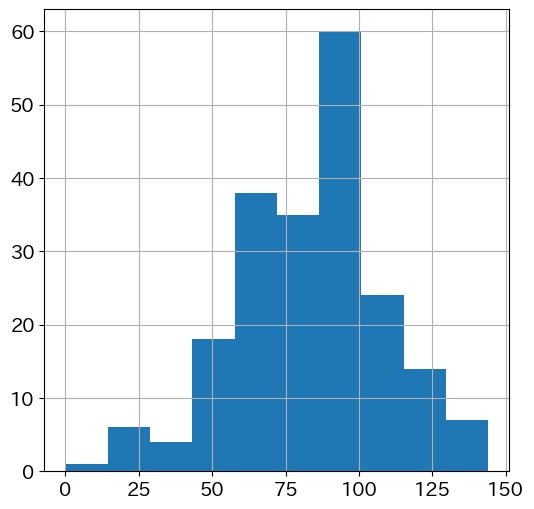

In [3]:
# データ準備、統計量確認、目的変数の可視化
df = pd.read_csv("test_scores.csv", index_col=0)
print(df.shape)
display(df.head())

display(df.describe())

plt.hist(df["score"])

(101, 11)


,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,39.000,0.000,2.000,3.000,1.000,1.000,50.000,1.000,1.000,0.000,1.000
12,109.000,1.000,1.000,0.000,0.000,0.000,48.000,1.000,1.000,1.000,0.000
14,91.000,0.000,2.000,0.000,0.000,0.000,58.000,1.000,1.000,1.000,1.000
19,65.000,1.000,0.000,2.000,0.000,0.000,50.000,1.000,1.000,0.000,1.000
21,71.000,1.000,1.000,2.000,0.000,1.000,58.000,0.000,0.000,1.000,1.000


,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
count,101.000,101.000,101.000,101.000,101.000,101.000,101.000,101.000,101.000,101.000,101.000
mean,87.762,0.505,1.069,0.871,0.139,0.238,53.347,0.416,0.723,0.376,0.436
std,22.710,0.502,0.863,0.956,0.347,0.428,3.422,0.495,0.450,0.487,0.498
min,28.000,0.000,0.000,0.000,0.000,0.000,48.000,0.000,0.000,0.000,0.000
25%,68.000,0.000,0.000,0.000,0.000,0.000,50.000,0.000,0.000,0.000,0.000
50%,92.000,1.000,1.000,1.000,0.000,0.000,53.000,0.000,1.000,0.000,0.000
75%,104.000,1.000,2.000,2.000,0.000,0.000,56.000,1.000,1.000,1.000,1.000
max,144.000,1.000,3.000,3.000,1.000,1.000,59.000,1.000,1.000,1.000,1.000


(array([ 2.000,  0.000, 18.000, 12.000,  8.000, 25.000, 22.000,  8.000,
         4.000,  2.000]),
 array([ 28.000,  39.600,  51.200,  62.800,  74.400,  86.000,  97.600,
        109.200, 120.800, 132.400, 144.000]),
 <BarContainer object of 10 artists>)

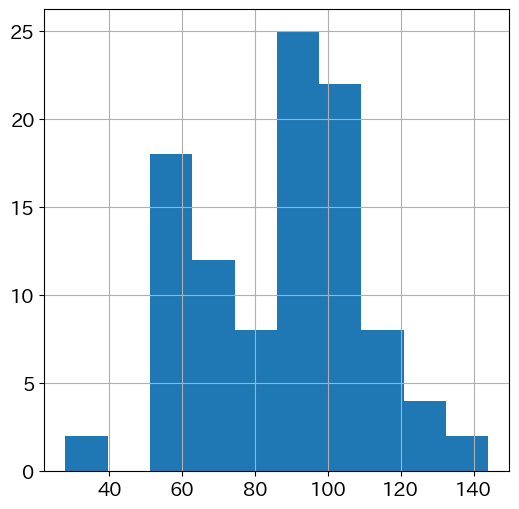

In [4]:
# 欠損値除去、統計量確認、目的変数の可視化
# データ準備、統計量確認、目的変数の可視化
df1 = df.dropna().astype(float)

print(df1.shape)
display(df1.head())

display(df1.describe())

plt.hist(df1["score"])

In [5]:
# 目的変数と説明変数の指定
y = df1["score"]
X = df1.drop("score", axis=1)
# 説明変数の標準化
X = (X-X.mean()) / X.std()

In [6]:
# モデル構築に必要な変数定義
columns = X.columns.values
columns

array(['male', 'siblings', 'family_inv', 'non_english', 'prev_disab',
       'age_test', 'non_severe_hl', 'mother_hs', 'early_ident',
       'non_white'], dtype=object)

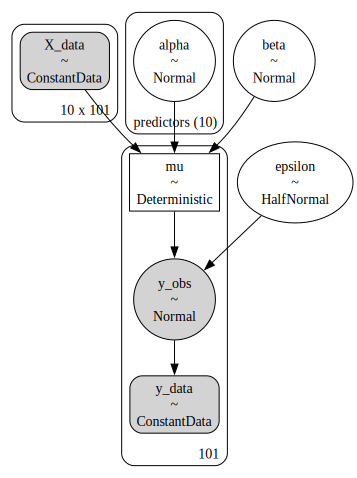

In [7]:
# 確率モデルの定義。coordsで説明変数のカラム名指定。
model = pm.Model(coords={"predictors":columns})
with model:
    # 観測データを定数としてConstantDataで定義
    X_data = pm.ConstantData("X_data", X.T)
    y_data = pm.ConstantData("y_data", y)

    # パラメータを確率変数として定義
    # alpha: Normal, beta: Normal
    # alphaは次元数を指定する。prdictorsで設定可能。
    alpha = pm.Normal("alpha", mu=0, sigma=10, dims="predictors")
    beta = pm.Normal("beta", mu=100, sigma=25)

    # muを確率変数としてDeterministicで定義
    mu = pm.Deterministic("mu", alpha @ X_data + beta)

    # 誤差項を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=25)

    # 観測値を持つ目的変数を確率変数として定義
    y_obs = pm.Normal("y_obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)


In [8]:
# サンプリング
with model:
    idata = pm.sample(chains=2,
                      tune=1000,
                      draws=1000,
                      target_accept=0.95,
                      random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


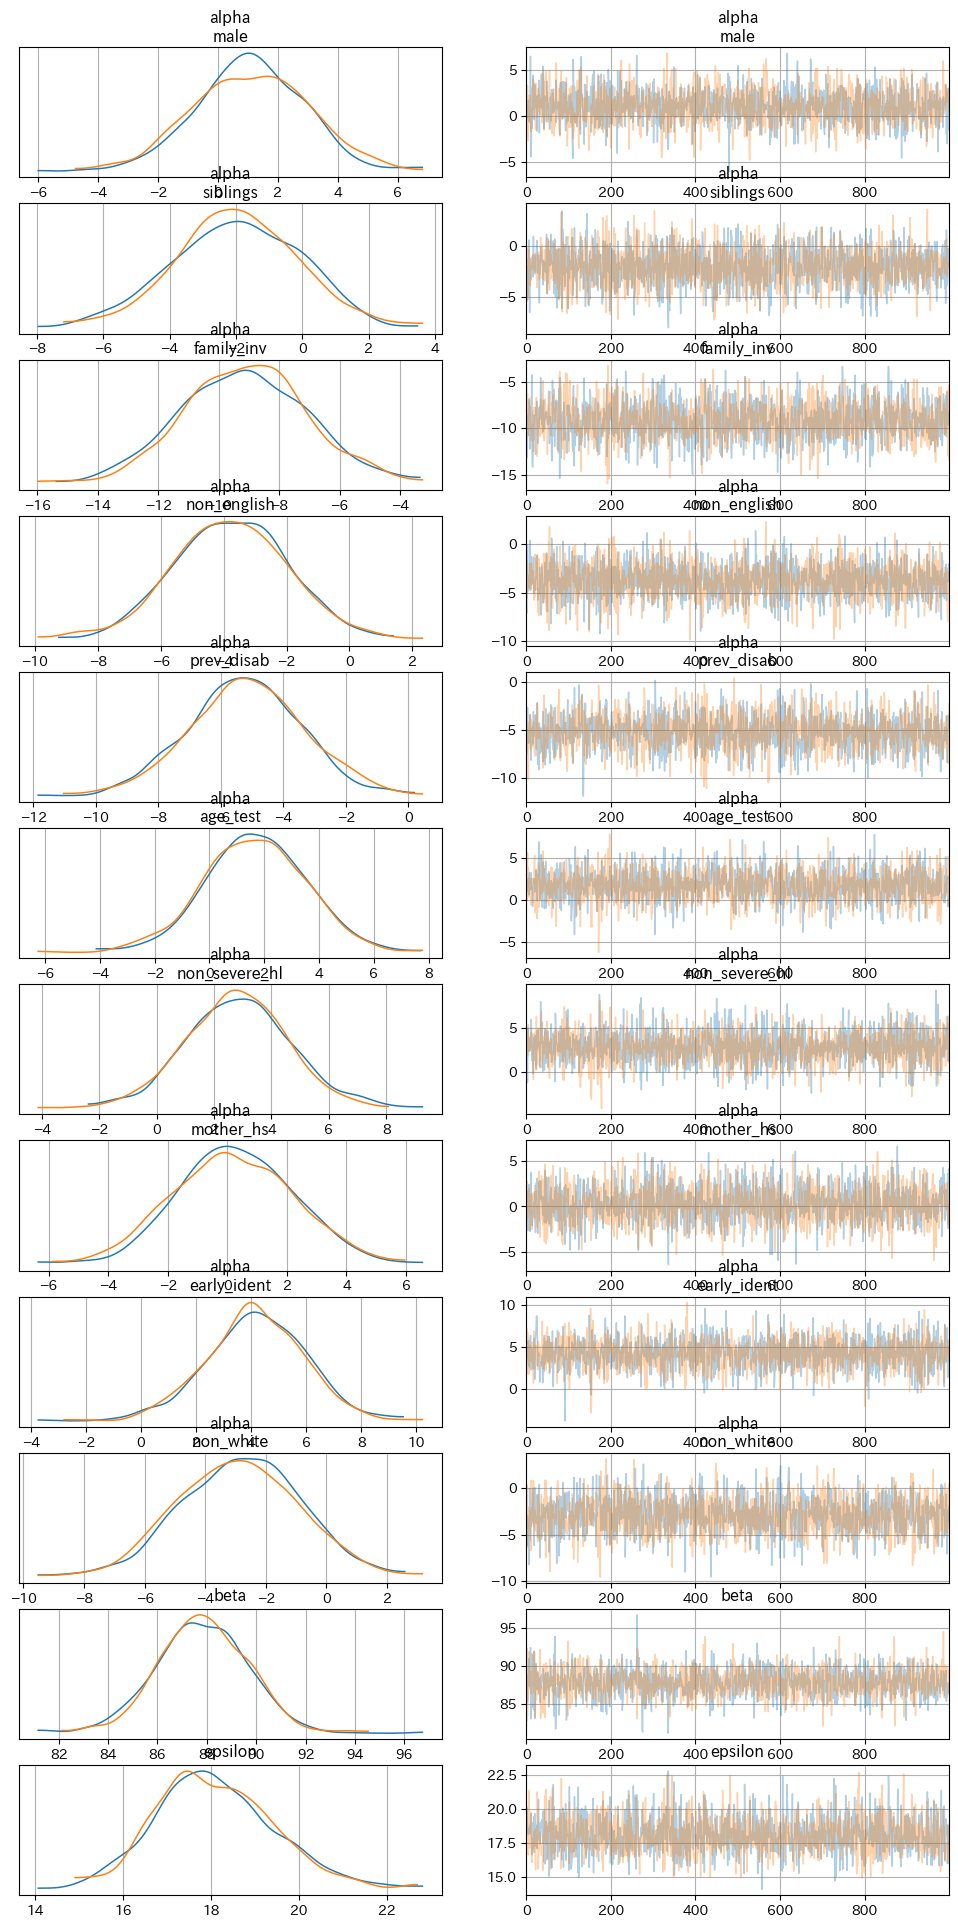

In [9]:
# 可視化
az.plot_trace(idata, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout;

In [10]:
summary = pm.summary(idata, var_names=["alpha"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],1.096,1.869,-2.339,4.572,0.041,0.037,2061.000,1477.000,1.000
alpha[siblings],-1.972,1.857,-5.087,1.882,0.039,0.033,2275.000,1468.000,1.000
alpha[family_inv],-9.134,2.062,-12.974,-5.173,0.050,0.035,1717.000,1521.000,1.000
alpha[non_english],-3.782,1.828,-7.242,-0.414,0.035,0.027,2728.000,1508.000,1.000
alpha[prev_disab],-5.193,1.822,-8.538,-1.746,0.041,0.030,1992.000,1503.000,1.000
alpha[age_test],1.679,1.843,-1.622,5.253,0.040,0.032,2129.000,1429.000,1.000
alpha[non_severe_hl],2.817,1.810,-0.824,6.147,0.036,0.028,2537.000,1267.000,1.000
alpha[mother_hs],0.245,1.994,-3.223,4.118,0.044,0.041,2045.000,1665.000,1.000
alpha[early_ident],4.167,1.768,0.686,7.344,0.039,0.028,2094.000,1509.000,1.000
alpha[non_white],-2.871,1.971,-6.349,0.894,0.048,0.034,1702.000,1485.000,1.000


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

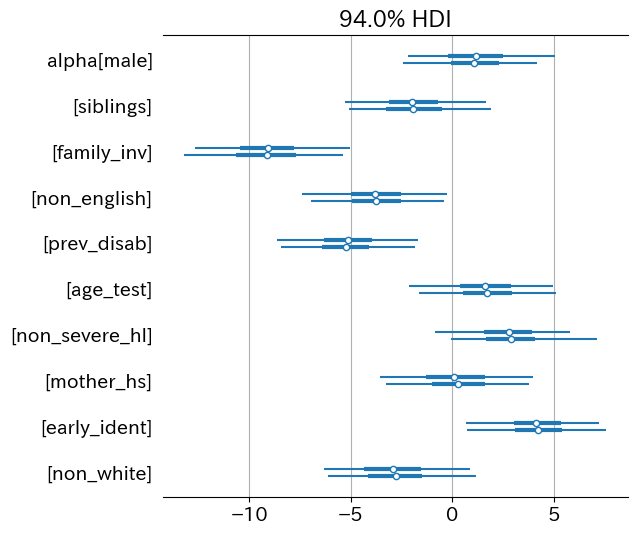

In [11]:
az.plot_forest(idata, var_names=["alpha"])
# family_inv, non_english, prev_disabは負の影響
# early_identは正の影響